# Blackbox NN for Query-26

    Datasize  IdleTimeout  BacklogTimeout  ExecutionTime
0         20           15              10             65
1         20           10               7             63
2         20           14               9             55
3         20           11               8             61
4         20           18              15             56
5         20           18              20             73
6         20            8               9             65
7         20           13              14             67
8         20            8              10             69
9         20            7               9             61
10       100           15              10             72
11       100           10               7             67
12       100           14               9             66
13       100           11               8             61
14       100           18              15             67
15       100           18              20             79
16       100            8      

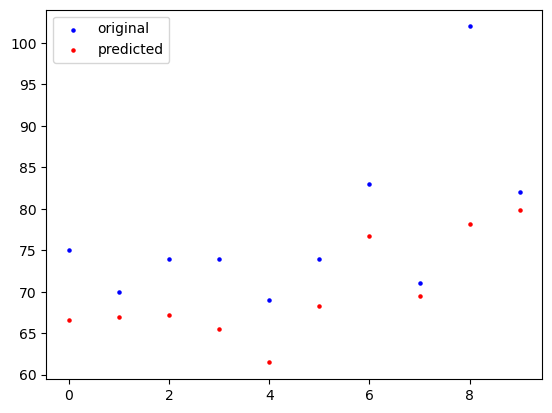

In [1]:
# This notebook is based on the methodology described in:
# Tariq, H., & Das, O. (2023). Execution Time Prediction Model that Considers Dynamic Allocation of Spark Executors.
# In: Gilly, K., Thomas, N. (eds) Computer Performance Engineering. EPEW 2023. LNCS, vol 14231. Springer, Cham.
# DOI: https://doi.org/10.1007/978-3-031-43185-2_23

import os, sys
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

train = pd.read_csv('query26_train_blackbox.csv')
print(train)

#training set and test set
train_set=train[train[['Datasize']].isin([20, 100, 200]).any(axis=1)]
test_set=train[train[['Datasize']].isin([500]).any(axis=1)]

print("TRAIN SET", train_set)
print("TEST SET", test_set)


#train set: x,y split
x_train_set = train_set[['Datasize', 'IdleTimeout', 'BacklogTimeout']]
y_train_set = train_set['ExecutionTime']


#test set: x,y split
x_test_set = test_set[['Datasize', 'IdleTimeout', 'BacklogTimeout']]
y_test_set = test_set['ExecutionTime']

print ("\ntrain/test split lengths ", len(x_train_set),len(x_test_set),len(y_train_set),len(y_test_set))

#normalizing training input data 
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(x_train_set)
test_x_scaled = scaler.fit_transform(x_test_set)


#5-fold
kfold = KFold(n_splits=5, shuffle=True)

#regressor parameters 
mlp = MLPRegressor(hidden_layer_sizes=(25,25), max_iter=10000, alpha= 0.001, 
                   solver= 'adam', activation='relu', batch_size= 1, 
                   learning_rate= 'adaptive', learning_rate_init= 0.01, 
                   beta_1= 0.9)

#fit training data 
training = mlp.fit(train_x_scaled, y_train_set)
print("\nconfiguration: ", training)

#cross validation on training set
results = cross_val_score(mlp, train_x_scaled, y_train_set, cv=kfold) 

#prediction
y_pred = mlp.predict(test_x_scaled)

actual = np.array(y_test_set)
pred = np.array(y_pred)

print ("\nprediction: ", pred) #array_output
print ("\nactual: ", actual)

mape = np.mean(np.abs((actual - pred)/actual)) * 100

print("mape = ", mape)
print("built-in function mape: ", mean_absolute_percentage_error(actual, pred))


x_ax = range(len(y_test_set))
plt.scatter(x_ax, y_test_set, s=5, color="blue", label="original")
plt.scatter(x_ax, pred, s=5, color="red", label="predicted")
plt.legend()
plt.show()